In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import sys
sys.path[1] = '/Users/vishwajit/.pyenv/versions/3.7.3/lib/python3.7/site-packages'
import tensorflow as tf
import folium
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.convolutional import MaxPooling1D
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import losses
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import datetime
from tqdm import tqdm
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
tf.__version__

'2.3.0'

In [3]:
drivers = ['D1','D2','D3','D4','D5','D6']
drive_types = ['AGGRESSIVE','DROWSY','NORMAL','NORMAL1','NORMAL2']
road_types = ['MOTORWAY','SECONDARY']
sensors = ['ACC','GPS']

In [4]:
acc_data = pd.DataFrame(columns=['driver','drive_type','road_type','timestamp','speed>50','accx','accy','accz',
                                 'accx_kf','accy_kf','accz_kf','roll','pitch','yaw'])
gps_data = pd.DataFrame(columns=['driver','drive_type','road_type','timestamp','speed','latitude','longitude',
                                 'altitude','vert_accuracy','horiz_accuracy','course','course_variation','1','2','3'])
for sensor in sensors:
    if sensor=='ACC':
        columns = ['timestamp','speed>50','accx','accy','accz','accx_kf','accy_kf','accz_kf',
                   'roll','pitch','yaw']
    else:
        columns = ['timestamp','speed','latitude','longitude','altitude','vert_accuracy','horiz_accuracy',
                   'course','course_variation','1','2','3']
    for driver in drivers:
        for road in road_types:
            if road == 'MOTORWAY':  
                for drive_type in ['AGGRESSIVE','DROWSY','NORMAL']:                  
                    try:
                        data_path = 'uah-driveset-extraction/'+driver+'_'+drive_type+'_'+road+'_'+sensor+'.txt'
                        df = pd.read_csv(data_path, delimiter=' ', names=columns,index_col=False)
                        df['driver'] = driver
                        df['drive_type'] = drive_type
                        df['road_type'] = road
                        if sensor == 'ACC':
                            acc_data = acc_data.append(df)
                        else:
                            gps_data = gps_data.append(df)
                    except:
                        print(f'{data_path} is not present!!')
            else:
                for drive_type in ['AGGRESSIVE','DROWSY','NORMAL1','NORMAL2']: 
                    try:
                        data_path = 'uah-driveset-extraction/'+driver+'_'+drive_type+'_'+road+'_'+sensor+'.txt'
                        df = pd.read_csv(data_path, delimiter=' ', names=columns,index_col=False)
                        df['driver'] = driver
                        df['drive_type'] = drive_type
                        df['road_type'] = road
                        if sensor == 'ACC':
                            acc_data = acc_data.append(df)
                        else:
                            gps_data = gps_data.append(df)
                    except:
                        print(f'{data_path} is not present!!')

uah-driveset-extraction/D6_AGGRESSIVE_SECONDARY_ACC.txt is not present!!
uah-driveset-extraction/D6_NORMAL1_SECONDARY_ACC.txt is not present!!
uah-driveset-extraction/D6_NORMAL2_SECONDARY_ACC.txt is not present!!
uah-driveset-extraction/D2_NORMAL_MOTORWAY_GPS.txt is not present!!
uah-driveset-extraction/D6_AGGRESSIVE_SECONDARY_GPS.txt is not present!!
uah-driveset-extraction/D6_NORMAL1_SECONDARY_GPS.txt is not present!!
uah-driveset-extraction/D6_NORMAL2_SECONDARY_GPS.txt is not present!!


In [48]:
gps_data

,index,driver,drive_type,road_type,timestamp,speed,latitude,longitude,altitude,vert_accuracy,horiz_accuracy,course,course_variation,1,2,3
0,0,D1,aggressive,motorway,8.94,95.3,40.505821,-3.361932,604.7,6,5,260.5,0.352,0,0,0
1,1,D1,aggressive,motorway,9.92,97.6,40.505779,-3.362244,605.4,6,5,258.4,2.461,0,0,0
2,2,D1,aggressive,motorway,10.98,101.8,40.505665,-3.362900,606.4,4,5,255.2,3.164,0,0,0
3,3,D1,aggressive,motorway,11.93,101.8,40.505665,-3.362900,606.4,4,5,255.2,3.164,0,0,0
4,4,D1,aggressive,motorway,12.99,101.9,40.505520,-3.363543,607.0,4,5,252.1,3.164,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29246,723,D6,drowsy,secondary,748.73,80.1,40.515694,-3.407346,618.8,4,5,147.7,1.055,0,2,0
29247,724,D6,drowsy,secondary,749.75,80.3,40.515526,-3.407207,618.5,4,5,148.0,0.352,0,2,0
29248,725,D6,drowsy,secondary,750.73,81.1,40.515354,-3.407065,617.9,4,5,149.4,1.758,0,2,0
29249,726,D6,drowsy,secondary,751.76,83.4,40.515175,-3.406932,617.6,4,5,151.2,3.164,0,2,0


In [5]:
acc_data.to_csv('UAH Accelerometer Data.csv')
gps_data.to_csv('UAH GPS Data.csv')

In [6]:
acc_data.reset_index(inplace=True)
gps_data.reset_index(inplace=True)

In [7]:
acc_data['drive_type'] = [x.lower() for x in acc_data['drive_type']]
acc_data['road_type'] = [x.lower() for x in acc_data['road_type']]
gps_data['drive_type'] = [x.lower() for x in gps_data['drive_type']]
gps_data['road_type'] = [x.lower() for x in gps_data['road_type']]

In [8]:
def get_data(sensor,driver='D1',drive_type='normal',road_type='motorway'):
    if sensor=='acc':
        return acc_data[(acc_data['driver']==driver)&(acc_data['drive_type']==drive_type)&
                        (acc_data['road_type']==road_type)].iloc[:,3:]
    elif sensor=='gps':
        return gps_data[(gps_data['driver']==driver)&(gps_data['drive_type']==drive_type)&
                        (gps_data['road_type']==road_type)].iloc[:,3:]

In [11]:
def plot_acceleration(driver,drive_type,road_type,acc_ax,KF=False,rolling=False):
    df = acc_data[(acc_data['driver']==driver)&(acc_data['drive_type']==drive_type)&
                  (acc_data['road_type']==road_type)]
    time = df['timestamp']
    if KF:
        kf = '_kf'
    else:
        kf = ''
    if acc_ax == 'x':
        a = 'accx'
    elif acc_ax == 'y':
        a = 'accy'
    elif acc_ax == 'z':
        a = 'accz'
    acc = df[a+kf]
    acc.reindex(time)
    plt.figure(figsize = (20,3))
    if rolling:
        acc = acc.rolling(rolling).mean().dropna()
        plt.plot(acc.index,acc.values)
        plt.title(driver+'_'+drive_type+'_'+road_type+'_'+a+kf+'_rolling_window='+str(rolling))
        plt.show()
        return
    plt.plot(time,acc)
    plt.title(driver+'_'+drive_type+'_'+road_type+'_'+a+kf)
    plt.show()

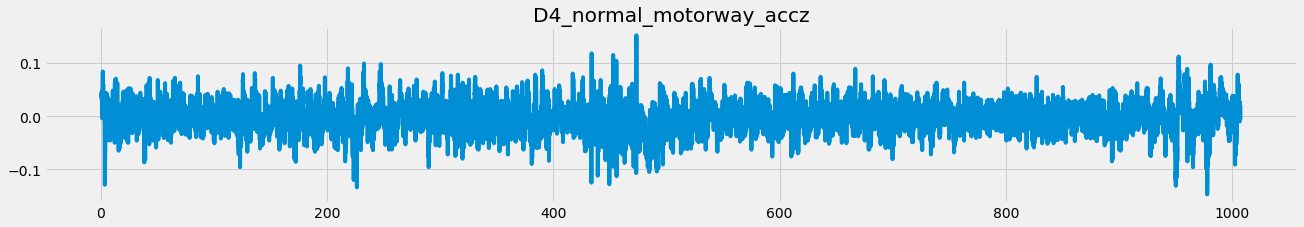

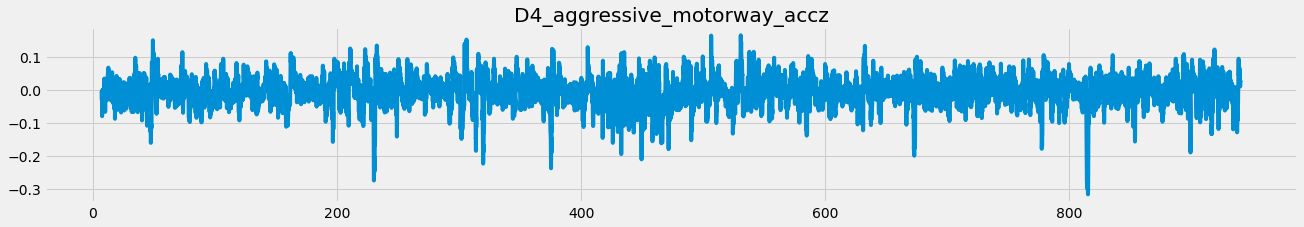

In [16]:
plot_acceleration('D4','normal','motorway','z')
plot_acceleration('D4','aggressive','motorway','z')

In [44]:
def plot_driving_path(driver,drive_type,road_type):
    df = gps_data[(gps_data['driver']==driver)&(gps_data['drive_type']==drive_type)&
                  (gps_data['road_type']==road_type)]
    points = df[['latitude','longitude']].values
    drive_path = folium.Map(location=list(points[0]))
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(drive_path)
    return drive_path

In [47]:
plot_driving_path('D2','normal','secondary')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
def plot_speed(driver,drive_type,road_type):
    df = gps_data[(gps_data['driver']==driver)&(gps_data['drive_type']==drive_type)&
                  (gps_data['road_type']==road_type)]
    time = df['timestamp']
    speed = df['speed']
    plt.figure(figsize=(20,5))
    plt.plot(time,speed)
    plt.show()

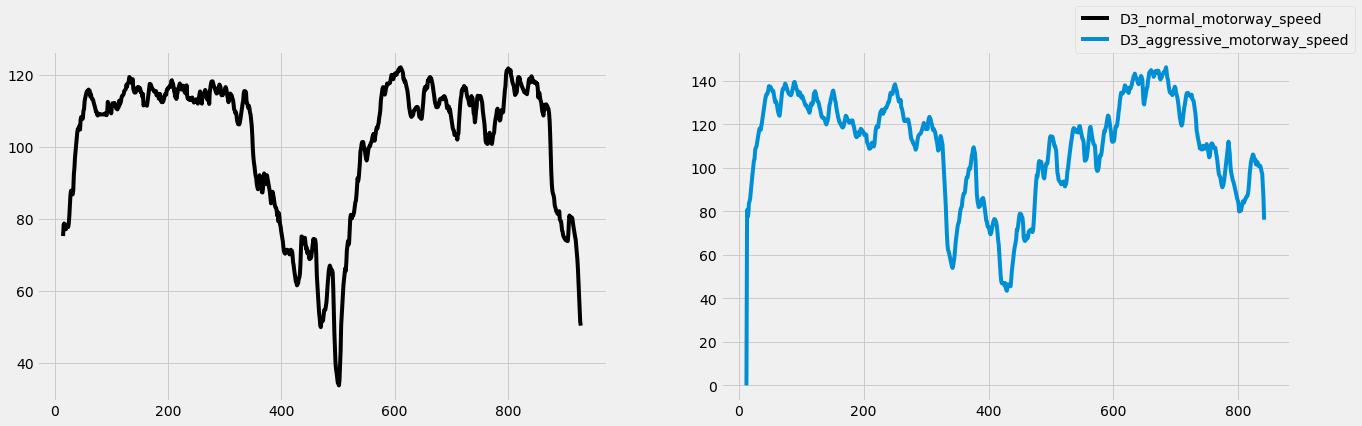

In [43]:
fig,ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(get_data('gps','D3','normal','motorway')['timestamp'],get_data('gps','D3','normal','motorway')['speed'],label='D3_normal_motorway_speed',c='black')
ax[1].plot(get_data('gps','D3','aggressive','motorway')['timestamp'],get_data('gps','D3','aggressive','motorway')['speed'],label='D3_aggressive_motorway_speed')
fig.legend()
plt.show()

In [ ]:
plot_speed('D1','normal','motorway')
plot_speed('D1','aggressive','motorway')

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(get_data('acc','D2','normal','motorway')['accz'].diff())
plt.plot(get_data('acc','D2','aggressive','motorway')['accz'].diff())

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(get_data('acc','D1','aggressive','motorway')['accz'].diff())

In [ ]:
#plot_acceration('D1','drowsy','motorway','z')
plot_acceration('D1','normal','motorway','z')
plot_acceration('D1','aggressive','motorway','z')

## ConvLSTM Model

In [8]:
get_data('acc','D2','normal','motorway')

,timestamp,speed>50,accx,accy,accz,accx_kf,accy_kf,accz_kf,roll,pitch,yaw
0,22.09,1,-0.026,0.005,0.006,-0.029,-0.018,0.014,-1.611,-0.001,-1.130
1,22.20,1,-0.037,0.020,-0.006,-0.026,0.001,0.006,-1.612,-0.002,-1.129
2,22.30,1,-0.022,-0.026,0.050,-0.026,-0.012,0.018,-1.616,-0.003,-1.128
3,22.39,1,0.019,-0.017,0.052,-0.009,-0.009,0.043,-1.617,-0.004,-1.127
4,22.49,1,-0.017,0.004,-0.009,-0.007,-0.009,0.026,-1.619,-0.004,-1.126
...,...,...,...,...,...,...,...,...,...,...,...
9211,954.64,0,-0.019,-0.054,-0.095,-0.022,-0.052,-0.089,-1.406,-0.148,1.698
9212,954.74,0,-0.030,-0.054,-0.112,-0.026,-0.052,-0.100,-1.396,-0.144,1.690
9213,954.84,0,-0.035,-0.053,-0.098,-0.032,-0.053,-0.107,-1.388,-0.140,1.682
9214,954.94,0,-0.028,-0.060,-0.104,-0.028,-0.055,-0.103,-1.379,-0.137,1.671


In [49]:
def window_1d_array(array,window_size,time_step):
    output = []
    n = array.shape[0]
    for i in np.arange(0,n,time_step):
        if i+window_size>n:
            break
        output.append(list(array[i:i+window_size]))
    return np.array(output)

In [50]:
def upsample_speed(driver='D1',drive_type='normal',road_type='motorway'):
    speed = get_data('gps',driver,drive_type,road_type)['speed']
    time = get_data('gps',driver,drive_type,road_type)['timestamp']
    speed.index = pd.to_datetime(time,unit='s')
    
    time_acc = pd.to_datetime(get_data('acc',driver,drive_type,road_type)['timestamp'],unit='s').values
    if speed.index[-1]<time_acc[-1]:
        speed[time_acc[-1]] = speed.values[-1]
    if speed.index[0]>time_acc[0]:
        speed[time_acc[0]] = speed.values[0]
    speed.sort_index(inplace=True)
    resample_index = pd.date_range(start=speed.index[0], end=speed.index[-1], freq='0.01S')
    dummy_series = pd.Series(speed, index=resample_index)
    speed = dummy_series.interpolate()
    return speed[time_acc].values

In [51]:
acc_data['speed'] = 0
combinations1 = list(acc_data.groupby(['driver','drive_type','road_type']).size().reset_index().drop(0,axis=1).values)
combinations2 = list(gps_data.groupby(['driver','drive_type','road_type']).size().reset_index().drop(0,axis=1).values)
combinations = []
for c1 in combinations1:
    for c2 in combinations2:
        if (c1==c2).all():
            combinations.append(c1)
            break
for x in tqdm(combinations):
    try:
        speed = upsample_speed(x[0],x[1],x[2])
        ind = list(acc_data[(acc_data['driver']==x[0])&(acc_data['drive_type']==x[1])&(acc_data['road_type']==x[2])].index)
        acc_data.loc[ind[0]:ind[-1],'speed'] = speed
    except:
        print(x[0],x[1],x[2])


 95%|█████████▍| 36/38 [00:09<00:00,  3.58it/s]

D6 drowsy motorway


100%|██████████| 38/38 [00:10<00:00,  3.61it/s]


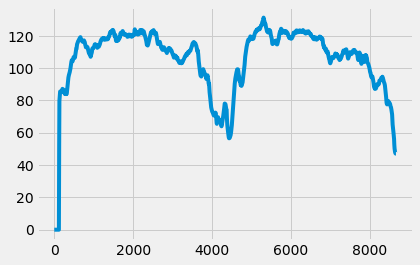

In [20]:
plt.plot(upsample_speed())

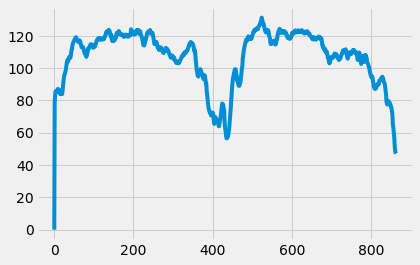

In [23]:
plt.plot(get_data('gps')['speed'].values)

In [37]:
get_data('acc','D1','aggressive','motorway')

,road_type,timestamp,speed>50,accx,accy,accz,accx_kf,accy_kf,accz_kf,roll,pitch,yaw,speed
0,motorway,8.02,1,-0.013,-0.021,0.011,-0.031,-0.009,0.013,-1.627,-0.011,0.294,95.3
1,motorway,8.12,1,-0.008,-0.005,-0.017,-0.018,-0.011,0.002,-1.626,-0.007,0.297,95.3
2,motorway,8.22,1,-0.013,-0.026,-0.012,-0.005,-0.011,-0.008,-1.625,-0.003,0.299,95.3
3,motorway,8.32,1,-0.049,-0.018,0.033,-0.029,-0.018,0.002,-1.626,0.001,0.302,95.3
4,motorway,8.43,1,0.016,0.009,0.014,-0.021,-0.008,0.021,-1.627,0.004,0.304,95.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,motorway,745.45,1,0.004,-0.009,0.019,-0.003,-0.017,0.009,-1.527,0.010,-2.639,81.1
7283,motorway,745.55,1,-0.013,-0.019,-0.049,0.004,-0.033,-0.005,-1.525,0.015,-2.636,81.1
7284,motorway,745.65,1,-0.082,-0.012,0.001,-0.043,-0.007,-0.024,-1.526,0.014,-2.637,81.1
7285,motorway,745.75,1,-0.041,-0.037,0.025,-0.052,-0.021,0.010,-1.528,0.014,-2.632,81.1


In [86]:
a = [[],[]]
y_ = [[],[]]
j = 0
for d_type in ['normal','aggressive']:
    w=60
    cols = ['accx_kf','accz_kf','accy_kf','accx','accy','accz','speed>50','roll','pitch','yaw','speed']
    m = len(cols)
    t=30
    n = window_1d_array(get_data('acc','D1',d_type,'motorway')[cols[0]].values,w,t)[:,:].shape[0]
    data = np.zeros((n,w,m))
    for i in range(m):
        data[:,:,i] = window_1d_array(get_data('acc','D1',d_type,'motorway')[cols[i]].values,w,t)[:,:]
    data = (data - np.mean(data,axis=0))/np.std(data,axis=0)
    y_pred = model.predict(data)
    y_pred = [0 if i<0.5 else 1 for i in y_pred]
    y_[j] = []
    a[j] = get_data('acc','D1',d_type,'motorway')['accz'].values *20
    for i in range(len(a[j])):
        try:
            y_[j].append(y_pred[i//30])
        except:
            break
    j+=1

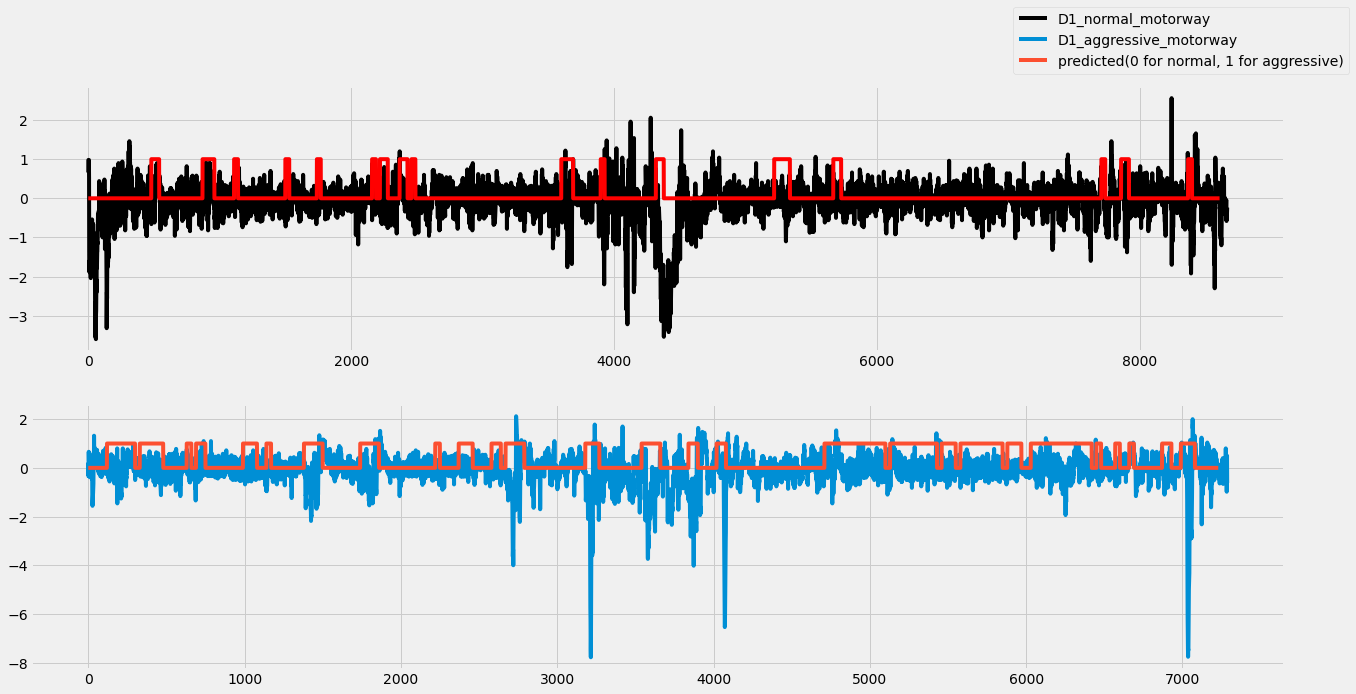

In [92]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(a[0],label='D1_normal_motorway',c='black')
ax[0].plot(y_[0],c='red')
ax[1].plot(a[1],label='D1_aggressive_motorway')
ax[1].plot(y_[1],label='predicted(0 for normal, 1 for aggressive)')
fig.legend()

In [63]:
cols = ['accx_kf','accz_kf','accy_kf','accx','accy','accz','speed>50','roll','pitch','yaw','speed']
m = len(cols)
w = 60
t = 30
road_type = ['motorway','secondary']
Data = []
for k in range(2):
    if k == 1:
        drive_type = ['normal1','normal2','aggressive']
        for l in range(3):
            for j in range(5):
                n = window_1d_array(get_data('acc',drivers[j],drive_type[l],road_type[k])[cols[0]].values,w,t)[:,:].shape[0]
                data = np.zeros((n,w,m))
                for i in range(m):
                    data[:,:,i] = window_1d_array(get_data('acc',drivers[j],drive_type[l],road_type[k])[cols[i]].values,w,t)[:,:]
                Data.append(data)
    if k == 0:
        drive_type = ['normal','aggressive']
        for l in range(2):
            for j in range(6):
                n = window_1d_array(get_data('acc',drivers[j],drive_type[l],road_type[k])[cols[0]].values,w,t)[:,:].shape[0]
                data = np.zeros((n,w,m))
                for i in range(m):
                    data[:,:,i] = window_1d_array(get_data('acc',drivers[j],drive_type[l],road_type[k])[cols[i]].values,w,t)[:,:]
                Data.append(data)
                
Y = np.array([0 for i in range(6)]+[1 for i in range(6)]+[0 for i in range(10)]+[1 for i in range(5)])
s = 0
for i in range(len(Data)):
    s += Data[i].shape[0]
X = np.zeros((s,w,m))
y = np.zeros(s)
k = 0
for i in range(len(Data)):
    n = Data[i].shape[0]
    X[k:k+n,:,:] = Data[i]
    y[k:k+n] = Y[i]
    k += n

X,y = shuffle(X,y)
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)

In [64]:
model = tf.keras.Sequential(
    [
        layers.Input(shape=(X.shape[1], X.shape[2])),
        layers.Conv1D(
            filters=128, kernel_size=10, padding="same", strides=2, activation="relu"
        ),
        layers.MaxPool1D(pool_size=3),
        layers.Dropout(rate=0.5),
        layers.Conv1D(
            filters=64, kernel_size=10, padding="same", strides=2, activation="relu"
        ),
        layers.MaxPool1D(pool_size=3),
        layers.Dropout(rate=0.5),
        layers.Bidirectional(layers.LSTM(32,return_sequences=True)),
        layers.Bidirectional(layers.LSTM(16)),
        layers.Dense(500,activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(100,activation='relu'),
        layers.Dense(1,activation='sigmoid')
    ]
)
model.compile(optimizer='Adam',loss=tf.keras.losses.Huber(),metrics=['acc'])
model.summary()
history = model.fit(X,y,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=20,
                    verbose=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 30, 128)           14208     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             81984     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 64)            

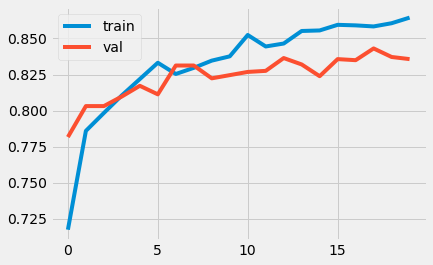

In [65]:
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='val')
plt.legend()

In [97]:
model = tf.keras.Sequential(
    [
        layers.Input(shape=(X.shape[1], X.shape[2])),
        layers.Conv1D(
            filters=128, kernel_size=10, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.5),
        layers.Conv1D(
            filters=64, kernel_size=10, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=64, kernel_size=10, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.5),
        layers.Conv1DTranspose(
            filters=128, kernel_size=10, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(optimizer=tf.keras.optimizers.Adam(lr =0.01), loss=tf.keras.losses.Huber(), metrics ='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 128)           14208     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            81984     
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 30, 64)            41024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 60, 128)           82048     
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 60, 1)             5

In [ ]:
history = model.fit(
    X,
    X,
    epochs=80,
    batch_size=128,
    validation_split=0.25,
    validation_batch_size =32,
    callbacks=[
       tf.keras.callbacks.EarlyStopping(monitor="loss", patience=8, mode="min")
   ],
)

In [ ]:
speed = get_data('gps')['speed']
time = get_data('gps')['timestamp']

In [ ]:
plt.plot(get_data('gps')['speed'])

In [18]:
acc_data.reset_index(inplace=True)

 95%|█████████▍| 36/38 [00:09<00:00,  3.51it/s]

D6 drowsy motorway


100%|██████████| 38/38 [00:10<00:00,  3.60it/s]
